<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E6%A7%98%E3%80%85%E3%81%AA%E6%AD%A3%E8%A6%8F%E5%8C%96%E3%81%A8K%E8%BF%91%E5%82%8D%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:

# 正規化の違いが kNN 異常検知に与える影響を可視化
#
# - x1,x2 は強い相関の楕円分布（正常）
# - x3 は巨大スケールのノイズ特徴（学習に無関係）→ raw だと距離が x3 に支配されやすい
# - 外れ値は x1,x2 の相関方向から外れた位置に配置（x3 は正常と同分布）
# - 正規化（standardize, robust, whiten）で検知性能と決定等高線がどう変わるかを比較
#
# - 各モード：閾値等高線 + 散布図（x1-x2平面）、スコア分布ヒスト、指標（Precision/Recall/F1）

import numpy as np
import matplotlib.pyplot as plt

In [26]:
# ===== パラメータ =====
np.random.seed(123)
k = 20                 # kNN の近傍数
alpha = 0.99           # 学習スコアの上位 α 分位を閾値に
modes = ["raw", "standardize", "robust", "whiten"]

n_train = 600          # 学習（正常）
n_test_norm = 300      # テスト（正常）
n_test_out = 40        # テスト（異常）


In [27]:
# ===== 1) データ生成 =====
# x1,x2 は強い相関を持つ楕円分布の正規データ、x3 は巨大スケールのノイズ（学習に無関係）
mu12 = np.array([0.0, 0.0])
Cov12 = np.array([[9.0, 8.2],
                  [8.2, 9.5]])
train_12 = np.random.multivariate_normal(mu12, Cov12, size=n_train)
testn_12  = np.random.multivariate_normal(mu12, Cov12, size=n_test_norm)

# 外れ値は相関方向から外れた位置（例：x1 高・x2 低 など）
out_centers = np.array([[ 10.0, -10.0],
                        [ -9.0,  10.0],
                        [ 13.0,   0.0],
                        [  0.0,  12.0]])
idx = np.random.randint(0, len(out_centers), size=n_test_out)
testo_12 = out_centers[idx] + np.random.normal(0, 1.0, size=(n_test_out,2))

# x3 は巨大スケール（距離を支配しやすい）。正常も外れ値も同じ分布→不要特徴
train_x3 = np.random.normal(0, 100.0, size=(n_train,1))        # 標準偏差 100
testn_x3 = np.random.normal(0, 100.0, size=(n_test_norm,1))
testo_x3 = np.random.normal(0, 100.0, size=(n_test_out,1))

# 3次元データ X = [x1,x2,x3]
train = np.hstack([train_12, train_x3])
testn = np.hstack([testn_12, testn_x3])
testo = np.hstack([testo_12, testo_x3])
test  = np.vstack([testn, testo])
labels = np.hstack([np.zeros(len(testn), dtype=int),
                    np.ones(len(testo), dtype=int)])

In [28]:

# ===== 2) ユーティリティ =====
# ユークリッド距離のペアワイズ計算
def pairwise_l2(A, B):
    A2 = np.sum(A*A, axis=1, keepdims=True)
    B2 = np.sum(B*B, axis=1, keepdims=True).T
    D2 = A2 + B2 - 2*(A @ B.T)
    D2 = np.maximum(D2, 0.0)
    return np.sqrt(D2)

# 適合率/再現率/F1
def prf1(pred, y):
    tp = int(((pred==1) & (y==1)).sum())
    fp = int(((pred==1) & (y==0)).sum())
    fn = int(((pred==0) & (y==1)).sum())
    precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
    recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    return precision, recall, f1, tp, fp, fn

In [29]:
# ===== 3) 変換器（正規化） =====
# 各モードの学習データから必要な統計量を推定し、apply で新データに適用
class Transformer:
    def __init__(self, mode, Xtrain):
        self.mode = mode
        self.mu = None
        self.std = None
        self.med = None
        self.iqr = None
        self.evals = None
        self.evecs = None

        if mode == "raw":
            pass

        elif mode == "standardize":
            # 平均・標準偏差で Z標準化
            self.mu = Xtrain.mean(axis=0)
            std = Xtrain.std(axis=0, ddof=1)
            std = np.where(std==0, 1.0, std)
            self.std = std

        elif mode == "robust":
            # 中央値・IQR でロバストスケーリング（外れ値の影響を抑える）
            self.med = np.median(Xtrain, axis=0)
            q75 = np.percentile(Xtrain, 75, axis=0)
            q25 = np.percentile(Xtrain, 25, axis=0)
            iqr = q75 - q25
            iqr = np.where(iqr==0, 1.0, iqr)
            self.iqr = iqr

        elif mode == "whiten":
            # まず Z標準化 → 共分散（相関）を固有分解 → Λ^{-1/2} でホワイトニング
            self.mu = Xtrain.mean(axis=0)
            std = Xtrain.std(axis=0, ddof=1)
            std = np.where(std==0, 1.0, std)
            self.std = std
            Xz = (Xtrain - self.mu)/self.std
            Cov = np.cov(Xz, rowvar=False)
            evals, evecs = np.linalg.eigh(Cov)
            evals = np.maximum(evals, 1e-9)  # 数値安定化
            self.evals = evals
            self.evecs = evecs

        else:
            raise ValueError("unknown mode")

    def apply(self, X):
        if self.mode == "raw":
            return X
        elif self.mode == "standardize":
            return (X - self.mu)/self.std
        elif self.mode == "robust":
            return (X - self.med)/self.iqr
        elif self.mode == "whiten":
            Xz = (X - self.mu)/self.std
            Lm12 = np.diag(self.evals**-0.5)
            return Xz @ self.evecs @ Lm12

In [30]:
# ===== 4) 可視化設定（x1-x2 平面の等高線用グリッド） =====
# 描画は x1-x2 平面で行う（x3 は 0 固定）。ただし距離・スコアは常に 3次元で計算
mins = np.min(np.vstack([train[:,:2], test[:,:2]]), axis=0) - 3.0
maxs = np.max(np.vstack([train[:,:2], test[:,:2]]), axis=0) + 3.0
gx, gy = np.meshgrid(np.linspace(mins[0], maxs[0], 240),
                     np.linspace(mins[1], maxs[1], 240))
grid_2d = np.c_[gx.ravel(), gy.ravel()]
grid_3d = np.hstack([grid_2d, np.zeros((grid_2d.shape[0],1))])  # x3=0 固定

[raw]  k=20, alpha=0.99  thr=52.5578  TP=0 FP=2 FN=40  precision=0.000 recall=0.000 F1=0.000


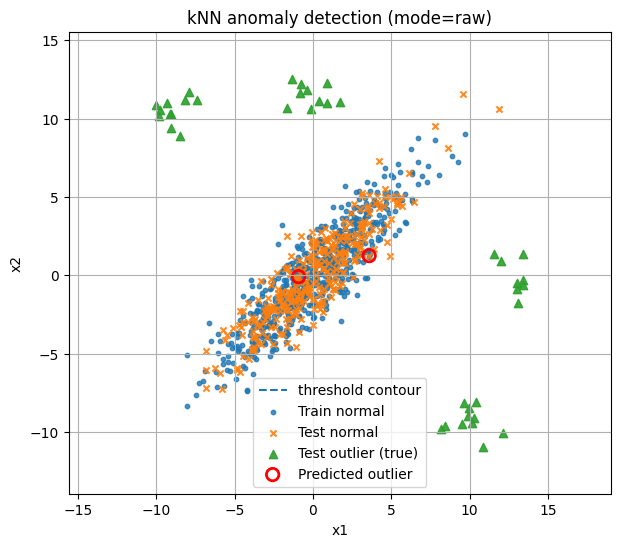

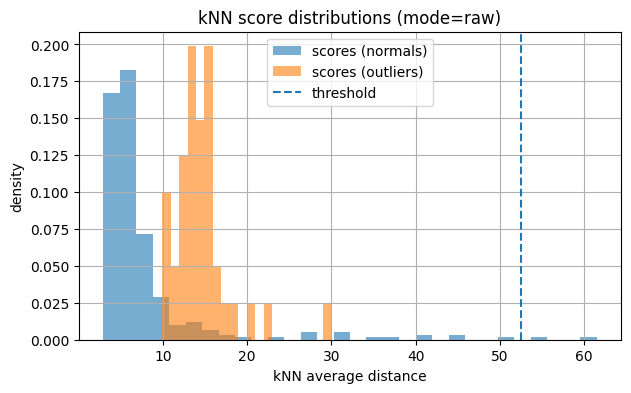

[standardize]  k=20, alpha=0.99  thr=1.4421  TP=40 FP=3 FN=0  precision=0.930 recall=1.000 F1=0.964


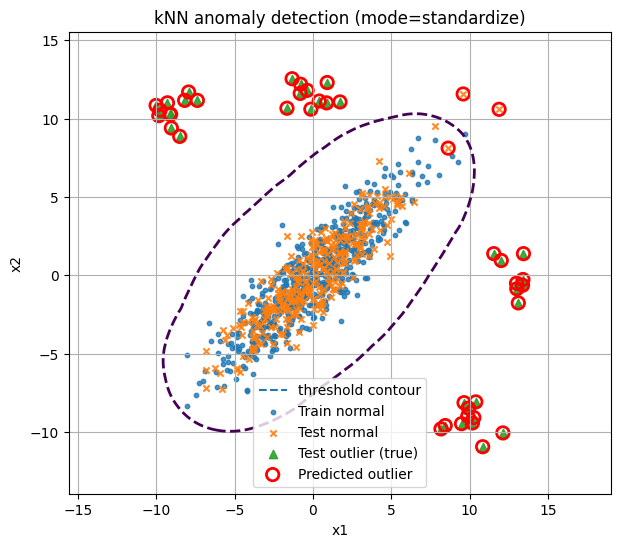

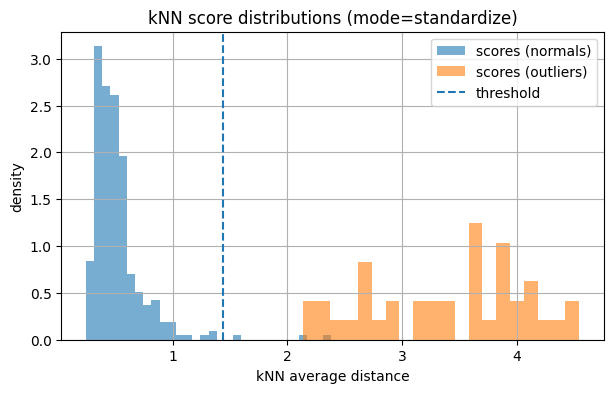

[robust]  k=20, alpha=0.99  thr=1.0812  TP=40 FP=3 FN=0  precision=0.930 recall=1.000 F1=0.964


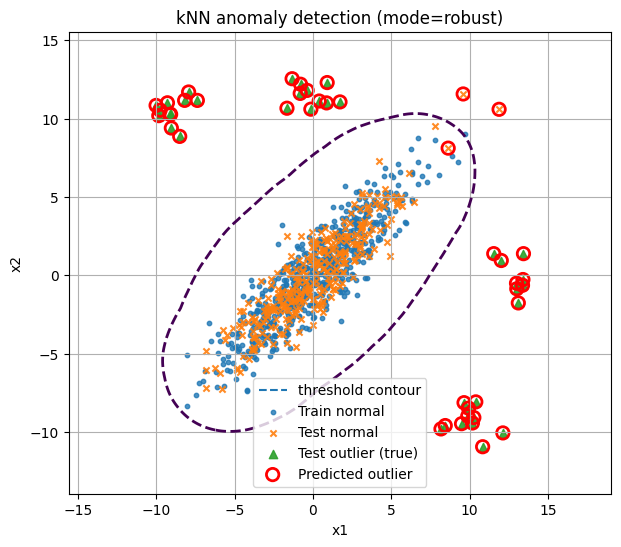

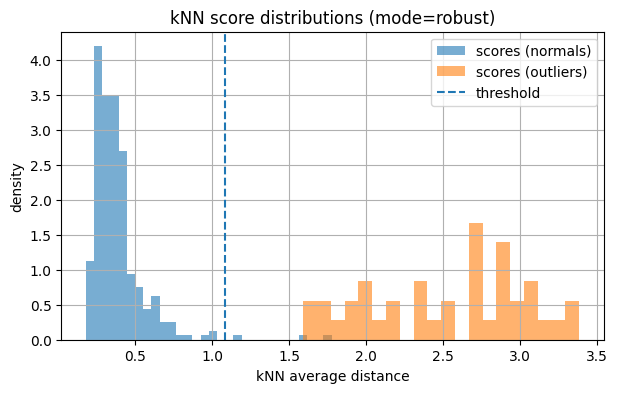

[whiten]  k=20, alpha=0.99  thr=1.5680  TP=40 FP=3 FN=0  precision=0.930 recall=1.000 F1=0.964


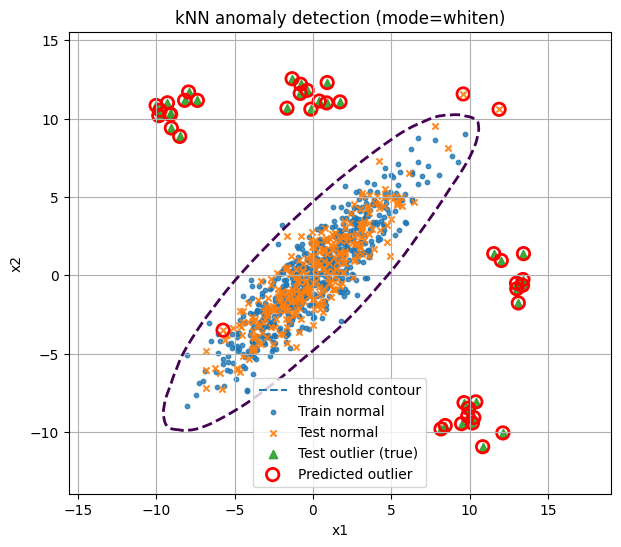

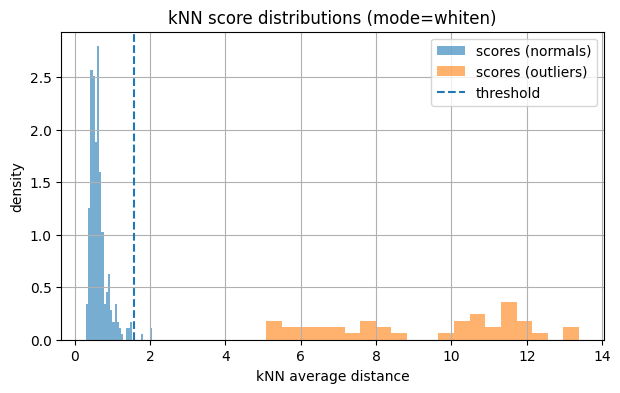

In [31]:
# ===== 5) 各モードで学習→判定→描画 =====
results = []

for mode in modes:
    # 変換
    tfm = Transformer(mode, train)
    tr = tfm.apply(train)
    tn = tfm.apply(testn)
    to = tfm.apply(testo)
    te = np.vstack([tn, to])
    gr = tfm.apply(grid_3d)

    # kNN スコア（学習→閾値、テスト→判定）
    Dtr = pairwise_l2(tr, tr)
    np.fill_diagonal(Dtr, np.inf)
    idx_k_tr = np.argpartition(Dtr, kth=k, axis=1)[:, :k]
    row = np.arange(tr.shape[0])[:, None]
    score_tr = Dtr[row, idx_k_tr].mean(axis=1)

    Dte = pairwise_l2(te, tr)
    idx_k_te = np.argpartition(Dte, kth=k, axis=1)[:, :k]
    row_te = np.arange(te.shape[0])[:, None]
    score_te = Dte[row_te, idx_k_te].mean(axis=1)

    thr = float(np.quantile(score_tr, alpha))
    pred = (score_te > thr).astype(int)

    # 指標
    precision, recall, f1, tp, fp, fn = prf1(pred, labels)
    results.append((mode, precision, recall, f1, tp, fp, fn, thr, score_te))

    print(f"[{mode}]  k={k}, alpha={alpha}  thr={thr:.4f}  "
          f"TP={tp} FP={fp} FN={fn}  precision={precision:.3f} recall={recall:.3f} F1={f1:.3f}")

    # 決定等高線（x1-x2 平面）
    Dg = pairwise_l2(gr, tr)
    idx_k_g = np.argpartition(Dg, kth=k, axis=1)[:, :k]
    row_g = np.arange(gr.shape[0])[:, None]
    score_g = Dg[row_g, idx_k_g].mean(axis=1).reshape(gx.shape)

    # 図1：等高線 + 散布図
    plt.figure(figsize=(7,6))
    plt.contour(gx, gy, score_g, levels=[thr], linestyles='--', linewidths=2)
    plt.plot([], [], linestyle='--', label="threshold contour")

    plt.scatter(train[:,0], train[:,1], s=10, alpha=0.8, label="Train normal")
    plt.scatter(testn[:,0], testn[:,1], s=20, marker='x', alpha=0.9, label="Test normal")
    plt.scatter(testo[:,0],  testo[:,1],  s=36, marker='^', alpha=0.9, label="Test outlier (true)")

    flagged = np.where(pred==1)[0]
    plt.scatter(test[flagged,0], test[flagged,1], s=80, facecolors='none', edgecolors='r',
                linewidths=2, label="Predicted outlier")

    plt.title(f"kNN anomaly detection (mode={mode})")
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.legend(loc="best"); plt.axis('equal'); plt.grid(True)
    plt.show()

    # 図2：スコア分布
    plt.figure(figsize=(7,4))
    plt.hist(score_te[labels==0], bins=30, density=True, alpha=0.6, label="scores (normals)")
    plt.hist(score_te[labels==1], bins=20, density=True, alpha=0.6, label="scores (outliers)")
    plt.axvline(thr, linestyle='--', label="threshold")
    plt.title(f"kNN score distributions (mode={mode})")
    plt.xlabel("kNN average distance"); plt.ylabel("density")
    plt.legend(); plt.grid(True)
    plt.show()